<a href="https://colab.research.google.com/github/daniel8691/Image_Rec_Tensorflow/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import json
import zipfile
import os



In [18]:
# used to delete folders with data
# !rm -rf "train"

In [19]:
# !unzip "drive/MyDrive/Dog_breed_project/dog_breed_data/dog-breed-identification.zip" -d "drive/MyDrive/Dog_breed_project/dog_breed_data"

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: drive/MyDrive/Dog_breed_project/dog_breed_data/train/83fad0718581a696132c96c166472627.jpg  
  in

## Problem
Identifying the breed of a dog given an image of a dog

WHen I take a photo of a dog, I want to know what breed of dog it is

## Data
The data was taken from Kaggle's dog breed identification competition: https://www.kaggle.com/c/dog-breed-identification/data

## Evaluation
This will be a file with prediction probabilities for each dog breed of each test image: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## Features
* dealing with images (unstructured data) so it's best to use deep learning/transfoer learning
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images have no labels, because we want to predict them


In [24]:
# import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:"+tf.__version__)
print(f"TFhub version: {hub.__version__}")

# Check for GPU availability
if tf.config.list_physical_devices("GPU"):
  print("Available")
else:
  print("not available")

TF version:2.4.1
TFhub version: 0.11.0
Available


## Get data ready (turn into Tensors)

The data has to be in numerical format for the ML model
Turn the images into numerical values (numerical representations)

Start by assessing the data and checking out the labels


In [25]:
# check out the labels of the data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/labels.csv")

In [26]:
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,8587cc1bb05b7997b4190485d07107a5,scottish_deerhound
freq,1,126


In [27]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [28]:
# check how many images each dog breed has
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

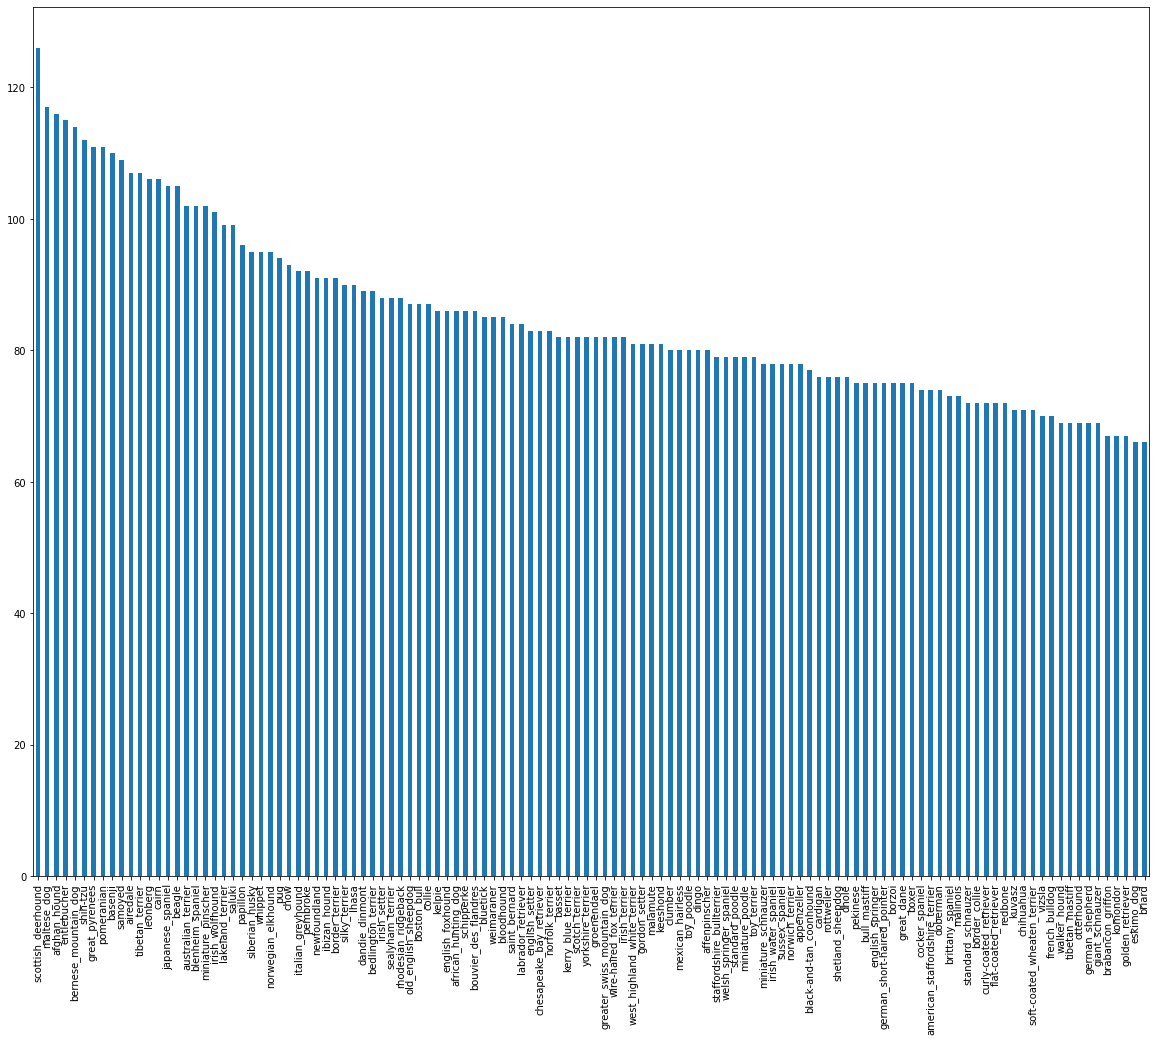

In [29]:
labels_csv['breed'].value_counts().plot(kind='bar', figsize=(20,16))

In [30]:
labels_csv['breed'].value_counts().median()

82.0

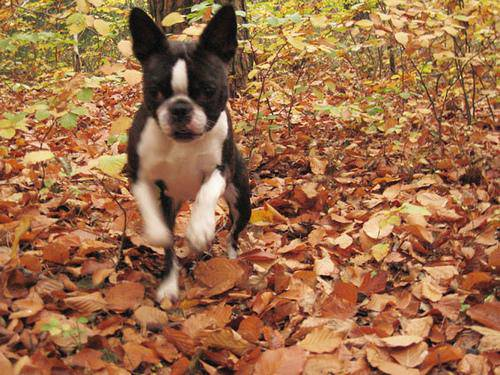

In [31]:
# view an image
from IPython.display  import Image
# pass in file name
Image("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting Images and their labels

get a list of all the image file path names

In [32]:
labels_csv['id'].count()

10222

In [33]:
# Create pathnames from image ID's
fileNames = [fname for fname in labels_csv['id']]

In [34]:
# check the first 10
fileNames[:5]

['000bec180eb18c7604dcecc8fe0dba07',
 '001513dfcb2ffafc82cccf4d8bbaba97',
 '001cdf01b096e06d78e9e5112d419397',
 '00214f311d5d2247d5dfe4fe24b2303d',
 '0021f9ceb3235effd7fcde7f7538ed62']

In [35]:
# get the file names with its file path 
fileNames_path = [f"/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/{fname}.jpg" for fname in labels_csv['id']]

In [36]:
fileNames_path[:5]

['/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [37]:
# check codes
import os
os.listdir("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/")[:10]

['ed650c72271b58dbac0fd5d91ebd206b.jpg',
 'f0efab499435ecd4e634b72f539fde9b.jpg',
 'efd68fb69d154ed0ff2dfea8f782f0d3.jpg',
 'ee92839020f1795e7eab77358e2528f1.jpg',
 'ea77bbe28a68e90a21bbef677493ad65.jpg',
 'f3929a0a7c3fede11ceb5d9e379778db.jpg',
 'f243cb6ec376a19f7de80e9c1a248518.jpg',
 'ecc1a9dcc73f00726ce6a7e79ef10a1c.jpg',
 'f2d5c11258efb9e8de45a81a6982f8f2.jpg',
 'ea9134791fb20bce0b72caabfa0947a6.jpg']

In [38]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Dog_breed_project/dog_breed_data/train/")) == len(fileNames_path):
  print("Filenames match actual number of files")
else:
  print("filenames don't match actual number of files")


Filenames match actual number of files


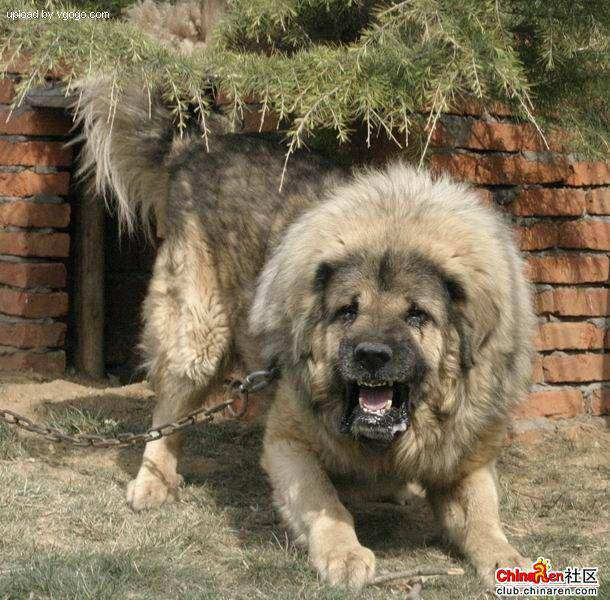

In [39]:
Image(fileNames_path[9000])

In [40]:
labels_csv['breed'][9000]

'tibetan_mastiff'